## Problem Set 06
### AST 8110, Fall 2022
##### Tyler Barna

In [6]:
## Importing packages (some of these may not be useful)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import time
#bigstart = time.time()


import sys
import os
import astropy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import random
import skimage

from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from numpy.linalg import norm ## to calculate magnitude of vector

from tqdm import tqdm
from scipy import meshgrid
from scipy.stats import binned_statistic as binstat
from scipy.integrate import quad, dblquad ## to integrate
from scipy.signal import argrelextrema as extrema 

from skimage.draw import circle_perimeter as cp

#%matplotlib inline
mpl.rcParams.update({"axes.grid" : False})
plt.style.context(("seaborn-colorblind",))
#plt.rc("text", usetex=True)
#plt.rc("font", family="serif")

## Set Seed
random.seed(8110)

### Problem 1

Take $b=0.07$ and assume sources are evenly spaced at distances of $0.05$ and both $x$ and $y$ go from $0 \rightarrow 1$.

The foreground masses are singular isothermal spheres (SIS) located at

$$
\begin{align}
(0.44,0.44) \\
(0.51,0.51) \\
(0.58,0.58) 
\end{align}
$$

SIS equations are given by
$$
\begin{equation}
\Psi  = b \left[x^2 +y^2\right]^{1/2} = b R
\end{equation}
$$

$$
\begin{equation}
\kappa = \frac{b}{2R}
\end{equation}
$$

$$
\begin{equation}
\gamma_1 = \frac{b \left[y^2 - x^2\right]}{2R^3}
\end{equation}
$$

$$
\begin{equation}
\gamma_2 = \frac{b xy}{R^3}
\end{equation}
$$

For $R= \sqrt{x^2 + y^2}$

We know that the lensing potentials add linearly, and because $\Psi = b R$, we can sum the values of $R$ when calculating other quantities.

In [7]:
## create array of source positions
x = np.arange(0, 1.05, 0.05) ## so we actually have 21 sources
y = np.arange(0, 1.05, 0.05)
xx, yy = np.meshgrid(x, y)

## define the lens locations
lens_xy = np.array([[0.44, 0.44], [0.51,0.51], [0.58,0.58]])

/home/tbarna/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


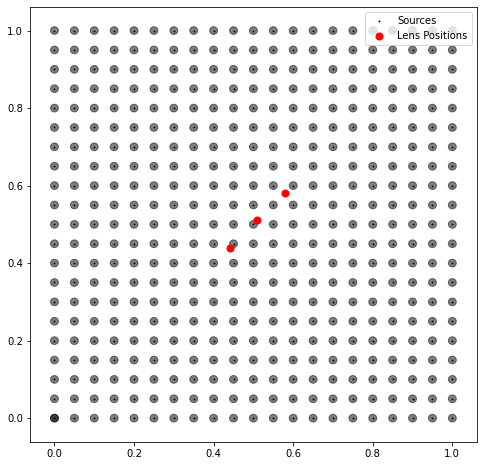

In [26]:
## plot the original source positions
fig, ax = plt.subplots(figsize=(8,8),facecolor="w")
ax.scatter(xx, yy,  color="k",s=0.8, label="Sources");
sr = 0.01 ## radius of each source

def plot_sources(x, y):
    circ = plt.Circle((x, y), sr, color="k", alpha=0.5, fill=True)
    ax.add_patch(circ)
    
ps = np.vectorize(plot_sources)
ps(xx,yy)
ax.scatter(lens_xy[:,0], lens_xy[:,1], color="r", s=50, label="Lens Positions");
ax.legend()
plt.show();

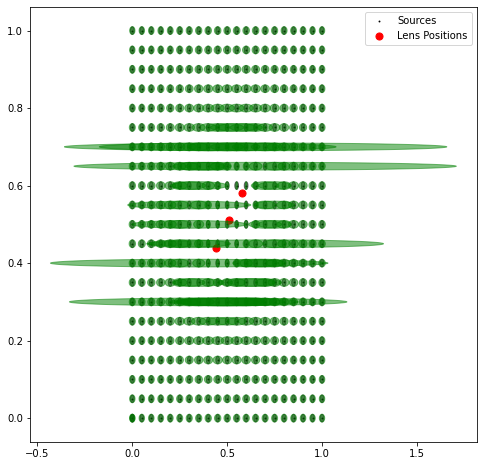

In [36]:
b = 0.07 
lens_xy = np.array([[0.44, 0.44], [0.51,0.51], [0.58,0.58]])

def R(source):
    """
    Calculates the distance R from the source to the lens and then sums over all lenses
    """
    xy = [np.array(source) - lens for lens in lens_xy]
    radii = [norm(item) for item in xy]
    #print(radii)
    return  radii

def gamma(source):
    """
    Calculates the gamma value at a given source position
    """
    x, y = source
    g1 = [b* (y**2 - x**2)/(2* rad **3) for rad in R(source)] 
    g2 = [- b * x * y / (rad **3) for rad in R(source)]
    return g1, g2

def kappa(source):
    """
    Calculates the kappa value at a given source position
    """
    kap = [b/(2*rad) for rad in R(source)] 
    return np.sum(kap)

def axis(source):
    A = sr/(1-2*kappa(source))
    B = sr
    return np.array([A,B])

def plot_img(x, y):
    ## calculate gamma and kappa
    g1, g2 = gamma([x,y])
    kap = kappa([x,y])
    
    t = np.linspace(0, 2*np.pi, 100)
    A, B = axis([x,y])
    x1 = x + A * np.cos(t)
    y1 = y + B * np.sin(t)
    
    ## define ellipse that can be rotated and create/apply rotation matrix
    ell = np.array([A * np.cos(t), B * np.sin(t)])
    
    ax.fill(x1, y1, color="g", alpha =0.5)

vec_plot_img = np.vectorize(plot_img)
   
fig, ax = plt.subplots(figsize=(8,8),facecolor="w")
ax.scatter(xx, yy,  color="k",s=0.8, label="Sources");
ps(xx,yy)
ax.scatter(lens_xy[:,0], lens_xy[:,1], color="r", s=50, label="Lens Positions");
vec_plot_img(xx,yy)
ax.legend()
plt.show();

### Problem 2

#### (a)

$$
\begin{equation}
n_U (f) = \left( f^{s_1} + f^{s_2} \right)^{-1}
\end{equation}
$$

$$
\begin{equation}
p\left(\mu\right) \text{d}\mu = \frac{1}{sqrt{\pi \sigma_\mu^2}} \text{exp}\left(-\frac{(\mu - \mu_0)^2}{\sigma_\mu^2}\right) \text{d}\mu
\end{equation}
$$

$$
\begin{equation}
n_L (f) = \int \frac{n_U (f/\mu) p(\mu)}{\mu} \text{d}\mu
\end{equation}
$$


#### (b)